# 1. Import Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Preparation

## Open initial dataset

In [2]:
df = pd.read_csv('sudut_hip.csv')

In [3]:
df.head()

,class,sudut_kiri,sudut_kanan
0,0,83.238612,87.706868
1,0,83.972850,90.118304
2,0,83.750809,88.807198
3,0,84.060725,89.476142
4,0,84.074376,89.978377


## Dataset Statistics

In [252]:
df.describe()

,class,sudut_kiri,sudut_kanan
count,1726.000000,1726.000000,1726.000000
mean,0.509270,144.636839,144.511807
std,0.500059,30.621131,30.440698
min,0.000000,23.176029,8.413124
25%,0.000000,123.273415,122.950741
50%,1.000000,155.795699,156.258125
75%,1.000000,173.330765,171.323107
max,1.000000,179.923583,179.995480


## Visualization of outliers

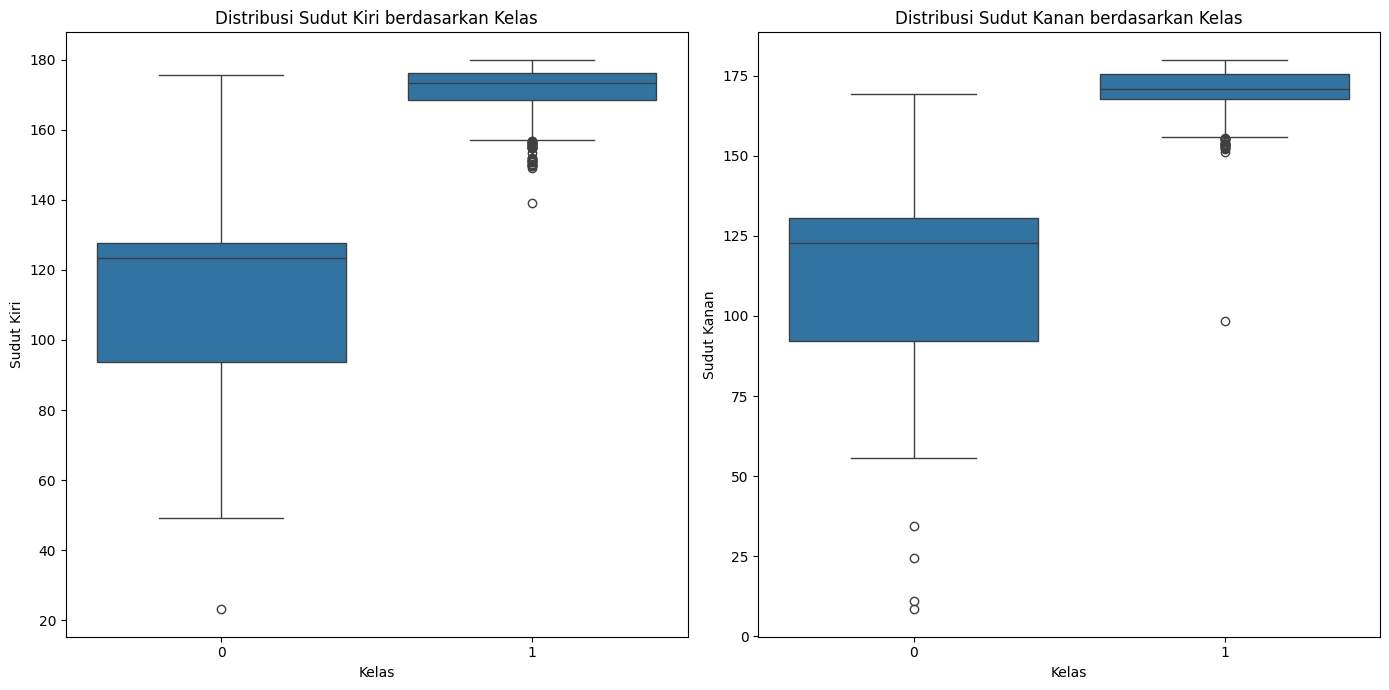

In [253]:
# Buat ukuran plot
plt.figure(figsize=(14, 7))

# Plot boxplot untuk sudut_kiri
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='sudut_kiri', data=df)
plt.title('Distribusi Sudut Kiri berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('Sudut Kiri')

# Plot boxplot untuk sudut_kanan
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='sudut_kanan', data=df)
plt.title('Distribusi Sudut Kanan berdasarkan Kelas')
plt.xlabel('Kelas')
plt.ylabel('Sudut Kanan')

# Tampilkan plot
plt.tight_layout()
plt.show()

## Check Outliers

In [255]:
# Fungsi untuk mendeteksi outliers
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Deteksi outliers untuk sudut_kiri
outliers_sudut_kiri = detect_outliers(df, 'sudut_kiri')
print(f"Outliers in sudut_kiri:\n{outliers_sudut_kiri}")

# Deteksi outliers untuk sudut_kanan
outliers_sudut_kanan = detect_outliers(df, 'sudut_kanan')
print(f"Outliers in sudut_kanan:\n{outliers_sudut_kanan}")

# Gabungkan semua outliers
all_outliers = pd.concat([outliers_sudut_kiri, outliers_sudut_kanan]).drop_duplicates()
print(f"All detected outliers:\n{all_outliers}")


Outliers in sudut_kiri:
    class  sudut_kiri  sudut_kanan
35      0   23.176029     34.51751
Outliers in sudut_kanan:
    class  sudut_kiri  sudut_kanan
32      0   79.666104    10.937288
33      0   62.185784     8.413124
34      0   56.846323    24.273804
35      0   23.176029    34.517510
All detected outliers:
    class  sudut_kiri  sudut_kanan
35      0   23.176029    34.517510
32      0   79.666104    10.937288
33      0   62.185784     8.413124
34      0   56.846323    24.273804


## Open Cleaned Dataset

In [4]:
df = pd.read_csv('sudut_hip_cleaned.csv')

In [5]:
df[df['class'] == 0].shape

(843, 3)

In [6]:
df[df['class'] == 1].shape

(879, 3)

## Shuffle Dataset

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

## Split Dataset

In [237]:
X = df.drop('class', axis=1)
y = df['class']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [239]:
print(f'Ukuran X_train: {X_train.shape}')
print(f'Ukuran X_test: {X_test.shape}')
print(f'Ukuran y_train: {y_train.shape}')
print(f'Ukuran y_test: {y_test.shape}')

Ukuran X_train: (1377, 2)
Ukuran X_test: (345, 2)
Ukuran y_train: (1377,)
Ukuran y_test: (345,)


## Setup GPU for training

In [241]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 3. Modelling

In [242]:
model = tf.keras.Sequential([
    layers.Dense(16, input_dim=2, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])


In [243]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [244]:
class ThresholdAccuracy(tf.keras.callbacks.Callback):
        def __init__(self, threshold=0.80):
            super(ThresholdAccuracy, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy is not None and val_accuracy is not None:
                if accuracy > self.threshold and val_accuracy > self.threshold:
                    print(f"\nEpoch {epoch+1}: accuracy telah mencapai {accuracy:.2%} dan val_accuracy mencapai {val_accuracy:.2%}, lebih besar dari threshold {self.threshold:.2%}. Berhenti training.")
                    self.model.stop_training = True

callback = ThresholdAccuracy(threshold=0.95)

Epoch 1/100
138/138 [==============================] - 2s 9ms/step - loss: 0.9305 - accuracy: 0.5527 - val_loss: 0.6391 - val_accuracy: 0.6145
Epoch 2/100
138/138 [==============================] - 1s 8ms/step - loss: 0.6626 - accuracy: 0.5846 - val_loss: 0.6180 - val_accuracy: 0.6290
Epoch 3/100
138/138 [==============================] - 1s 8ms/step - loss: 0.6429 - accuracy: 0.6028 - val_loss: 0.6053 - val_accuracy: 0.6609
Epoch 4/100
138/138 [==============================] - 1s 7ms/step - loss: 0.6144 - accuracy: 0.6311 - val_loss: 0.7063 - val_accuracy: 0.5159
Epoch 5/100
138/138 [==============================] - 1s 8ms/step - loss: 0.6202 - accuracy: 0.6282 - val_loss: 0.5833 - val_accuracy: 0.6203
Epoch 6/100
138/138 [==============================] - 1s 8ms/step - loss: 0.6034 - accuracy: 0.6529 - val_loss: 0.5979 - val_accuracy: 0.7594
Epoch 7/100
138/138 [==============================] - 1s 7ms/step - loss: 0.5773 - accuracy: 0.6928 - val_loss: 0.5584 - val_accuracy: 0.7623

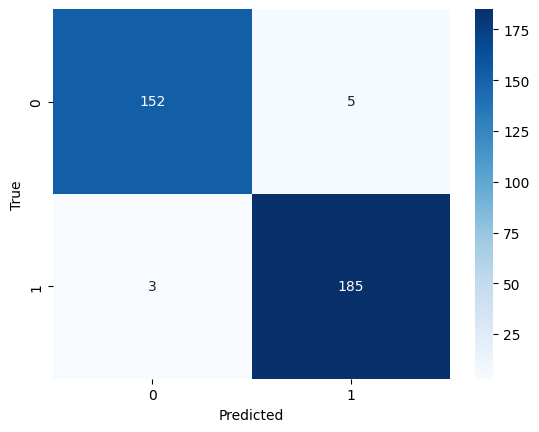

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       157
           1       0.97      0.98      0.98       188

    accuracy                           0.98       345
   macro avg       0.98      0.98      0.98       345
weighted avg       0.98      0.98      0.98       345



In [245]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

## Convert Model

In [246]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_bottom_position.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpwsrb7jq1\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpwsrb7jq1\assets


# 4. Testing

## Function to calculate angle

In [ ]:
def hitung_sudut(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    sudut = np.abs(radians * 180.0 / np.pi)
    
    if sudut > 180.0:
        sudut = 360 - sudut
        
    return sudut

## Testing model through video stream

In [249]:
import time

mp_drawing = mp.solutions.drawing_utils 
mp_pose = mp.solutions.pose

vid_path = "test3.mp4"
cap = cv2.VideoCapture(vid_path)
current_stage = ''

# Initiate Pose Model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Streaming the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to the desired window size
        frame = cv2.resize(frame, (720, 600))

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))
        try:
            if results.pose_landmarks:
                coords = results.pose_landmarks.landmark
                titik_11 = [coords[11].x, coords[11].y]
                titik_12 = [coords[12].x, coords[12].y]
                titik_23 = [coords[23].x, coords[23].y]
                titik_24 = [coords[24].x, coords[24].y]
                titik_25 = [coords[25].x, coords[25].y]
                titik_26 = [coords[26].x, coords[26].y]
                sudut_kiri = hitung_sudut(titik_11, titik_23, titik_25)
                sudut_kanan = hitung_sudut(titik_12, titik_24, titik_26)

                row = [sudut_kiri, sudut_kanan]
                row = np.expand_dims(row, axis=0)  # Add a batch dimension
                prediction = model.predict(row)
                print(f'Result: {prediction[0][0]}')
                
                if prediction[0][0] > 0.6:
                    current_stage = 'Correct'
                elif prediction[0][0] <= 0.6:
                    current_stage = 'Wrong'

                cv2.rectangle(image, (0, 0), (250, 60), (245, 117, 16), -1)

                cv2.putText(image, 'CLASS', (95, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, current_stage, (95, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                cv2.putText(image, 'PROB', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(prediction[0][0], 2)), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        except Exception as e:
            print(f"Error: {e}")


        # Stream video result
        cv2.imshow("Raw Cam Feed", image)

        # Press 'q' to stop the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        time.sleep(0.5)  # Jeda 100ms

    cap.release()
    cv2.destroyAllWindows()


Result: 0.5045410394668579
Result: 0.4141622483730316
Result: 0.34016695618629456
Result: 0.3080197870731354
Result: 0.3557042181491852
Result: 0.34634822607040405
Result: 0.25562191009521484
Result: 0.24707530438899994
Result: 0.35391226410865784
Result: 0.512114942073822
Result: 0.5455564260482788
Result: 0.5065346956253052
Result: 0.4657815396785736
Result: 0.4622829556465149
Result: 0.269557923078537
Result: 0.37558627128601074
Result: 0.6614527106285095
Result: 0.8039168119430542
Result: 0.46909651160240173
Result: 0.7384602427482605
Result: 0.8320134282112122
Result: 0.7631921172142029
Result: 0.5237833261489868
Result: 0.6400191187858582
Result: 0.7976471781730652
Result: 0.8162792325019836
Result: 0.7163100838661194
Result: 0.6728370189666748
Result: 0.618613600730896
Result: 0.4973890781402588
Result: 0.6972689032554626
Result: 0.6752813458442688
Result: 0.6735430955886841
Result: 0.4592786133289337
Result: 0.5654146075248718
Result: 0.6846526265144348
Result: 0.55933320522308